In [32]:
import matplotlib.pyplot as plt
import torch
import torch.nn as nn
import torchvision.transforms as T
from IPython.display import clear_output
from torch.optim import Adam
from torch.utils.data import DataLoader
from torchvision.datasets import CIFAR10
from tqdm import tqdm

In [33]:
train_dataset = CIFAR10('Data/cifar10', train=True, transform=T.ToTensor(), download=True)
valid_dataset = CIFAR10('Data/cifar10', train=False, transform=T.ToTensor(), download=True)

train_loader = DataLoader(train_dataset, batch_size=128, shuffle=True, num_workers=8, pin_memory=True)
valid_loader = DataLoader(valid_dataset, batch_size=128, shuffle=False, num_workers=8, pin_memory=True)

Files already downloaded and verified
Files already downloaded and verified


In [34]:
def create_simple_conv_cifar():
    conv_model = nn.Sequential(
        nn.Conv2d(in_channels=3, out_channels=32, kernel_size=5),  # 32x28x28
        nn.BatchNorm2d(32),
        nn.ReLU(),

        # nn.Dropout2d(p=0.2),
        # nn.MaxPool2d(kernel_size=2),

        nn.Conv2d(in_channels=32, out_channels=64, kernel_size=5),  # 64x24x24
        nn.BatchNorm2d(64),
        nn.ReLU(),

        nn.Dropout2d(p=0.2),
        nn.MaxPool2d(kernel_size=2),

        nn.Flatten(),
        nn.Linear(12 * 12 * 64, 256),

        nn.BatchNorm1d(256),
        nn.Dropout(p=0.2),

        nn.ReLU(),
        nn.Linear(256, 10)
    )

    return conv_model

In [35]:
def whole_train_valid_cycle(model, num_epochs, title):
    train_loss_history, valid_loss_history = [], []
    train_accuracy_history, valid_accuracy_history = [], []

    loss_fn = nn.CrossEntropyLoss()
    optimizer = Adam(model.parameters(), lr=1e-3)

    for epoch in range(num_epochs):
        train_loss, train_accuracy = train(model, optimizer, loss_fn, train_loader)
        valid_loss, valid_accuracy, res = evaluate(model, loss_fn, valid_loader)

        train_loss_history.append(train_loss)
        valid_loss_history.append(valid_loss)

        train_accuracy_history.append(train_accuracy)
        valid_accuracy_history.append(valid_accuracy)

        clear_output()

        plot_stats(
            train_loss_history, valid_loss_history,
            train_accuracy_history, valid_accuracy_history,
            title
        )

        if valid_accuracy >= 0.7:
            torch.save(res, 'task8_res.pt')
            print('res saved!')
            break


In [36]:
def plot_stats(
        train_loss: list[float],
        valid_loss: list[float],
        train_accuracy: list[float],
        valid_accuracy: list[float],
        title: str
):
    plt.figure(figsize=(16, 8))

    plt.title(title + ' loss')

    plt.plot(train_loss, label='Train loss')
    plt.plot(valid_loss, label='Valid loss')
    plt.legend()
    plt.grid()

    plt.show()

    plt.figure(figsize=(16, 8))

    plt.title(title + ' accuracy')

    plt.plot(train_accuracy, label='Train accuracy')
    plt.plot(valid_accuracy, label='Valid accuracy')
    plt.legend()
    plt.grid()

    plt.show()

In [37]:
def train(model, optimizer, loss_fn, loader) -> tuple[float, float]:
    model.train()

    train_loss = 0
    total = 0
    correct = 0

    device = torch.device("cuda:0" if torch.cuda.is_available() else "cpu")

    for x, y in tqdm(loader, desc='Train'):
        x, y = x.to(device), y.to(device)

        optimizer.zero_grad()

        output = model(x)

        loss = loss_fn(output, y)

        train_loss += loss.item()

        loss.backward()

        optimizer.step()

        _, y_pred = torch.max(output, 1)
        total += y.size(0)
        correct += (y_pred == y).sum().item()

    train_loss /= len(train_loader)
    accuracy = correct / total

    print(accuracy)

    return train_loss, accuracy

In [38]:
@torch.inference_mode()
def evaluate(model, loss_fn, loader):
    model.eval()

    total_loss = 0
    total = 0
    correct = 0

    device = torch.device("cuda:0" if torch.cuda.is_available() else "cpu")

    res = torch.Tensor(device=device)

    for x, y in tqdm(loader, desc='Validate'):
        x, y = x.to(device), y.to(device)

        output = model(x)

        loss = loss_fn(output, y)

        total_loss += loss.item()

        _, y_pred = torch.max(output, 1)
        total += y.size(0)
        correct += (y_pred == y).sum().item()
        res = torch.cat((res, y_pred), 0)

    total_loss /= len(loader)
    accuracy = correct / total
    
    print(accuracy)
    
    return total_loss, accuracy, res

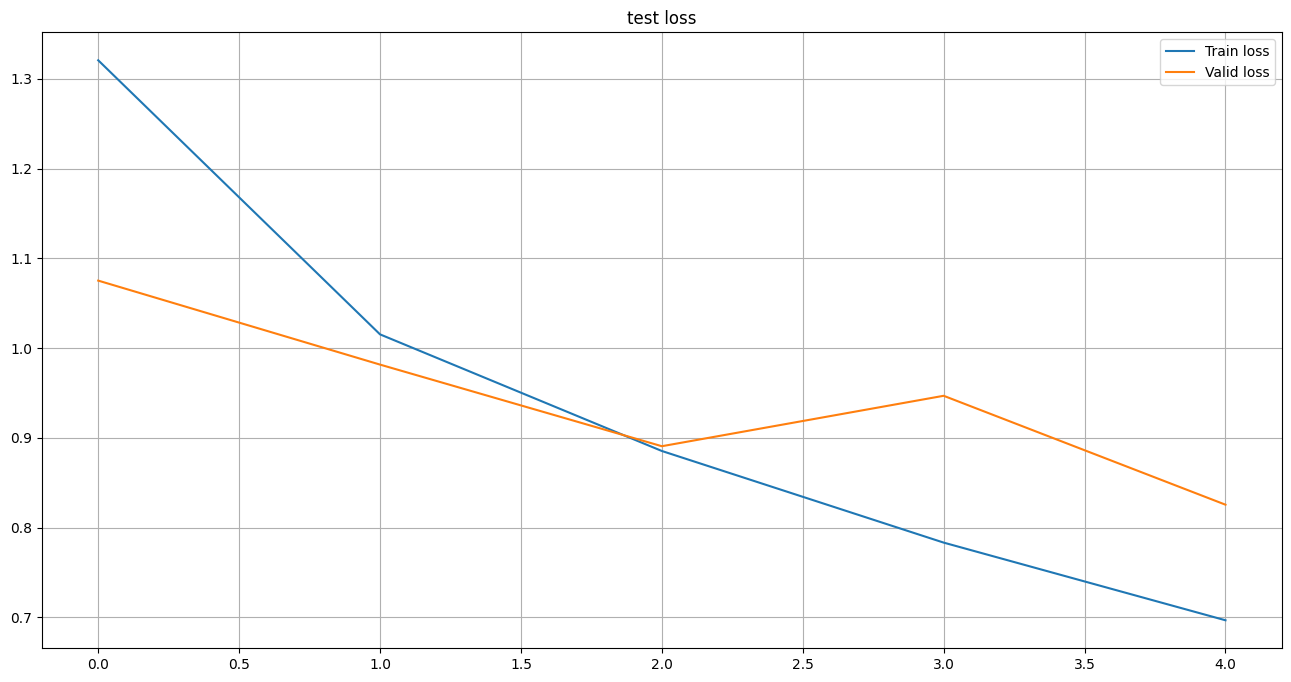

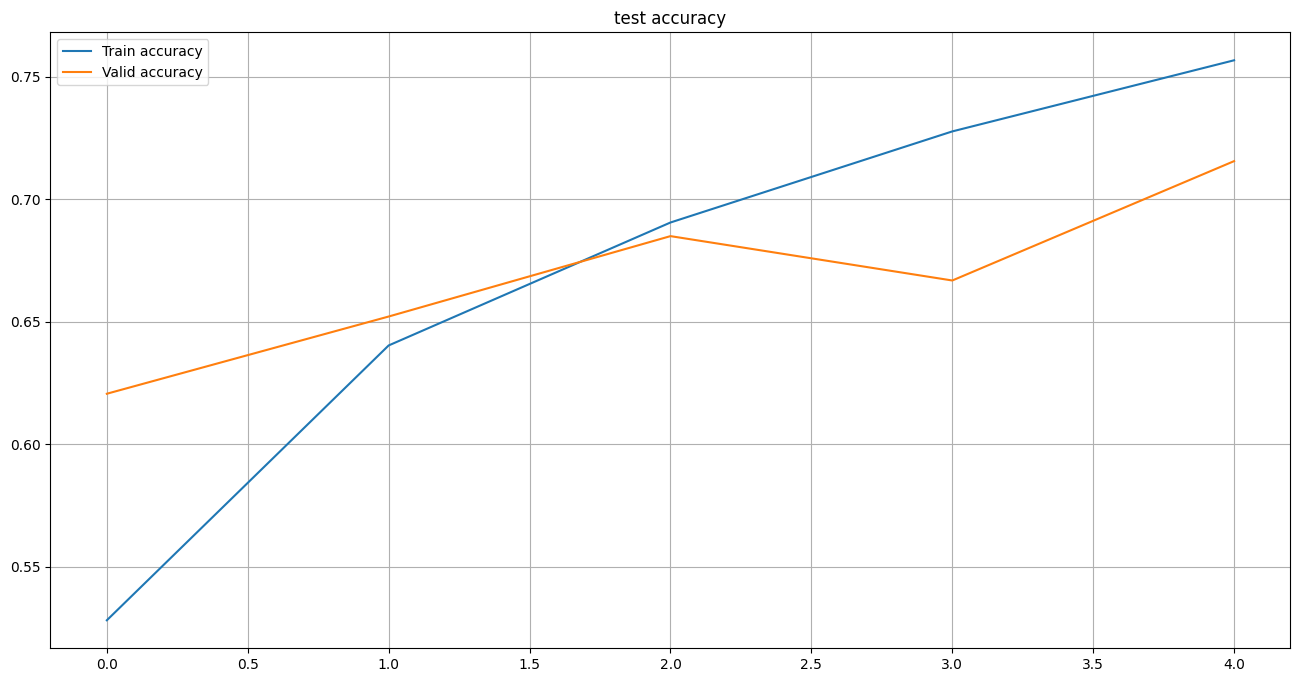

res saved!


In [39]:
whole_train_valid_cycle(create_simple_conv_cifar(), 5, 'Task8')